# Home Loan Approval/Denial: Models, part A

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from sklearn import set_config

set_config(display="diagram")

In [3]:
# Local functions
from modeling_preparation import get_X_y, refit_strategy

#### Auxiliary variables and functions

In [4]:
filename_input = "data-hdma-eastbay-2019-2022-processed"

In [5]:
def get_info(model):
    if isinstance(model, GridSearchCV):
        print(f"train score = {model.best_estimator_.score(X_train, y_train)}")
        print(f"test score = {model.best_estimator_.score(X_test, y_test)}")
    else:
        print(f"train score = {model.score(X_train, y_train)}")
        print(f"test score = {model.score(X_test, y_test)}")

## Loading the processed data

In [6]:
X_train, X_test, y_train, y_test = get_X_y(filename_input, ohe_transform=True)

## Models: no hyperparameter search

### Baseline: DummyClassifier

In [7]:
baseline = DummyClassifier().fit(X_train, y_train)
get_info(baseline)

train score = 0.6579427439636188
test score = 0.6579407427676685


### Logistic Regression

In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
get_info(model)
print(classification_report(y_test, model.predict(X_test)))

train score = 0.7706761528738777
test score = 0.7733084021221933
              precision    recall  f1-score   support

           0       0.74      0.52      0.61     22501
           1       0.78      0.90      0.84     43280

    accuracy                           0.77     65781
   macro avg       0.76      0.71      0.73     65781
weighted avg       0.77      0.77      0.76     65781



### Decision Tree

train score = 0.7773477711322205
test score = 0.7807269576321431
              precision    recall  f1-score   support

           0       0.88      0.41      0.56     22501
           1       0.76      0.97      0.85     43280

    accuracy                           0.78     65781
   macro avg       0.82      0.69      0.71     65781
weighted avg       0.80      0.78      0.75     65781



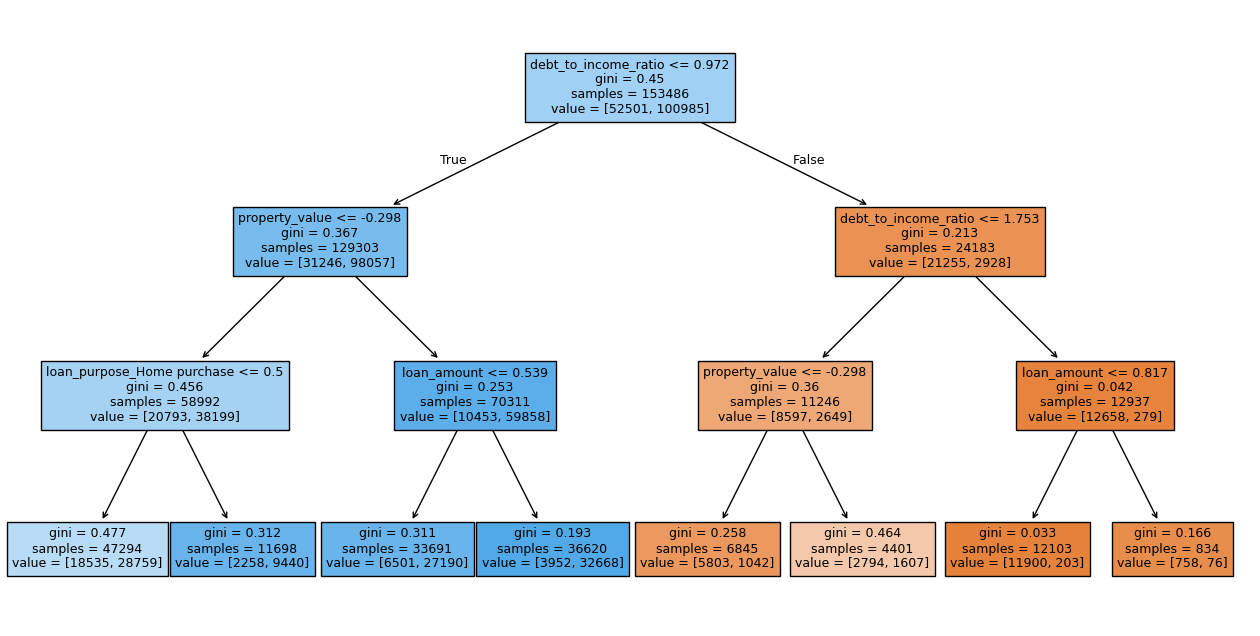

In [9]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

get_info(model)
print(classification_report(y_test, model.predict(X_test)))

f, ax = plt.subplots(figsize=(16, 8))
plot_tree(
    model,
    feature_names=X_train.columns,
    fontsize=9,
    filled=True,
    ax=ax,
)
plt.show()

## Models: hyperparameter search

### Logistic Regression

In [10]:
grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000),
    param_grid={
        "C": 10.0 ** np.array([-5, -4, -3, -2, -1, 0, 1, 2]),
    },
    scoring=["precision", "recall"],
    refit=refit_strategy,
    cv=8,
    # verbose=4,
    n_jobs=-1,
).fit(X_train, y_train)

All grid-search results:
precision: 0.683 (±0.001), recall: 0.999 (±0.000), for {'C': 1e-05}
precision: 0.767 (±0.002), recall: 0.935 (±0.001), for {'C': 0.0001}
precision: 0.781 (±0.002), recall: 0.906 (±0.002), for {'C': 0.001}
precision: 0.783 (±0.002), recall: 0.901 (±0.001), for {'C': 0.01}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 0.1}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 1.0}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 10.0}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 100.0}

Models with a precision higher than 0.7633234025688646:
precision: 0.767 (±0.002), recall: 0.935 (±0.001), for {'C': 0.0001}
precision: 0.781 (±0.002), recall: 0.906 (±0.002), for {'C': 0.001}
precision: 0.783 (±0.002), recall: 0.901 (±0.001), for {'C': 0.01}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 0.1}
precision: 0.783 (±0.002), recall: 0.900 (±0.002), for {'C': 1.0}
precision: 0.783 (±0.002), recall: 0.900 (±

In [11]:
grid_lr.best_estimator_.score(X_test, y_test)

0.772958757087913

In [12]:
get_info(grid_lr)
grid_lr_preds = grid_lr.predict(X_test)
print(classification_report(y_test, grid_lr_preds))

train score = 0.769874776852612
test score = 0.772958757087913
              precision    recall  f1-score   support

           0       0.78      0.46      0.58     22501
           1       0.77      0.93      0.84     43280

    accuracy                           0.77     65781
   macro avg       0.78      0.70      0.71     65781
weighted avg       0.77      0.77      0.75     65781



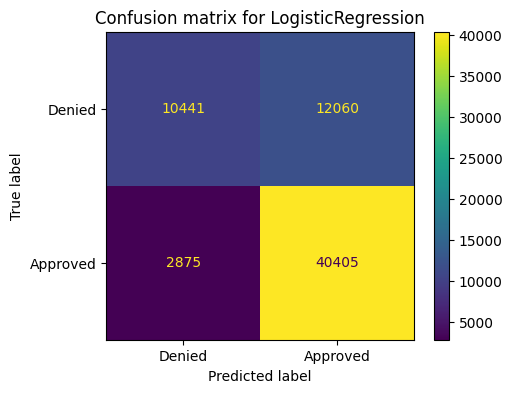

In [13]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    grid_lr_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for LogisticRegression")
plt.show()

### Decision Tree

In [29]:
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [6, 16, 32],
        "min_samples_split": [500, 1000, 2000],
    },
    scoring=["precision", "recall"],
    refit=refit_strategy,
    cv=8,
    # verbose=4,
    n_jobs=-1,
    return_train_score=True,
).fit(X_train, y_train)

All grid-search results:
precision: 0.772 (±0.004), recall: 0.962 (±0.010), for {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 500}
precision: 0.771 (±0.004), recall: 0.964 (±0.010), for {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 1000}
precision: 0.771 (±0.004), recall: 0.964 (±0.010), for {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2000}
precision: 0.796 (±0.002), recall: 0.923 (±0.007), for {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 500}
precision: 0.795 (±0.002), recall: 0.927 (±0.004), for {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 1000}
precision: 0.787 (±0.005), recall: 0.938 (±0.008), for {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2000}
precision: 0.797 (±0.002), recall: 0.920 (±0.007), for {'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 500}
precision: 0.795 (±0.002), recall: 0.927 (±0.004), for {'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 1000}
precision: 0.

In [30]:
grid_dt.best_params_

{'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 1000}

In [31]:
get_info(grid_dt)
grid_dt_preds = grid_dt.predict(X_test)
print(classification_report(y_test, grid_dt_preds))

train score = 0.7996169031703217
test score = 0.7990605189948465
              precision    recall  f1-score   support

           0       0.80      0.55      0.65     22501
           1       0.80      0.93      0.86     43280

    accuracy                           0.80     65781
   macro avg       0.80      0.74      0.75     65781
weighted avg       0.80      0.80      0.79     65781



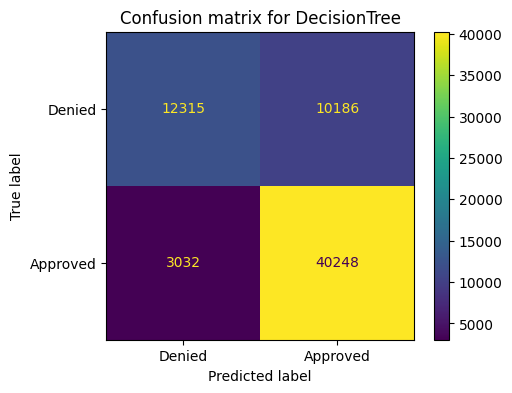

In [32]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    grid_dt_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for DecisionTree")
plt.show()

### SVM

In [18]:
# Split train into smaller datasets for SVM
_, X_small, _, y_small = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
X_small = X_small.reset_index(drop=True)
y_small = y_small.reset_index(drop=True)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_small, test_size=0.3, stratify=y_small, random_state=2
)

In [19]:
X_small.shape

(15349, 31)

In [20]:
grid_svm = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid={
        "C": 10.0 ** np.array([-2, -1, 0, 1, 2]),
    },
    scoring=["precision", "recall"],
    refit=refit_strategy,
    # verbose=4,
    cv=4,
    n_jobs=-1,
).fit(X_small_train, y_small_train)

All grid-search results:
precision: 0.745 (±0.004), recall: 0.987 (±0.002), for {'C': 0.01}
precision: 0.766 (±0.004), recall: 0.972 (±0.003), for {'C': 0.1}
precision: 0.778 (±0.003), recall: 0.957 (±0.004), for {'C': 1.0}
precision: 0.786 (±0.004), recall: 0.924 (±0.009), for {'C': 10.0}
precision: 0.787 (±0.007), recall: 0.868 (±0.013), for {'C': 100.0}

Models with a precision higher than 0.7782675539541192:
precision: 0.786 (±0.004), recall: 0.924 (±0.009), for {'C': 10.0}
precision: 0.787 (±0.007), recall: 0.868 (±0.013), for {'C': 100.0}

precision: 0.786 (±0.004), recall: 0.924 (±0.009), for {'C': 10.0}


Selected model:

mean_score_time           2.420413
mean_test_recall          0.924459
std_test_recall           0.009165
mean_test_precision       0.785931
std_test_precision        0.004007
rank_test_recall                 4
rank_test_precision              2
params                 {'C': 10.0}
Name: 3, dtype: object


In [21]:
grid_svm.best_params_

{'C': 10.0}

In [22]:
print(grid_svm.best_estimator_.score(X_small_test, y_small_test))
print(grid_svm.best_estimator_.score(X_test, y_test))
print(grid_svm.best_estimator_.score(X_train, y_train))

0.7921824104234527
0.7875526367796172
0.7885670354299414


In [23]:
grid_svm_preds = grid_svm.predict(X_test)
print(classification_report(y_test, grid_svm_preds))

              precision    recall  f1-score   support

           0       0.79      0.51      0.62     22501
           1       0.79      0.93      0.85     43280

    accuracy                           0.79     65781
   macro avg       0.79      0.72      0.74     65781
weighted avg       0.79      0.79      0.77     65781



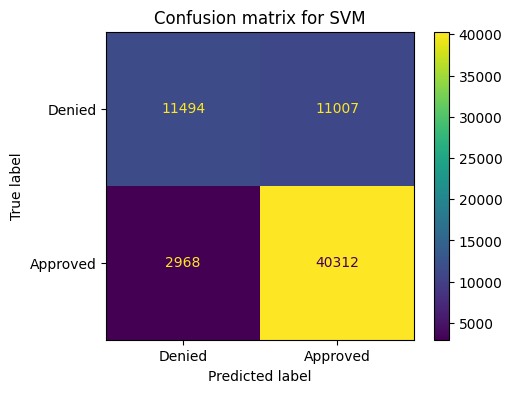

In [24]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    grid_svm_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for SVM")
plt.show()

## Models: ROC curve

In [37]:
y_test_preds_All = {}

# Load exported data from the other models
for model_name in ['AdaBoost', 'HistGradBoost', 'RandomForest', 'XGBoost', 'NN']:
    y_test_preds_All[model_name] = np.loadtxt(f'results/y_test_preds-{model_name}.csv', delimiter=',')

# Calculate model predictions in this notebook
y_test_preds_All["LogReg"] = grid_lr.predict_proba(X_test)
y_test_preds_All["DecTree"] = grid_dt.predict_proba(X_test)
y_test_preds_All["SVM"] = grid_svm.predict_proba(X_test)

In [38]:
y_test_preds_list = [(x, y[:,1]) if y.ndim > 1 else (x,y) for x,y in y_test_preds_All.items()]

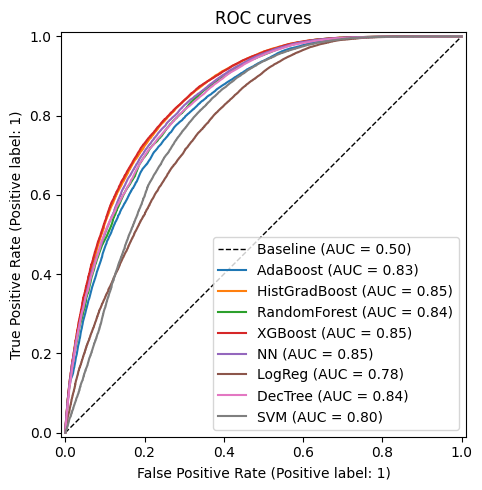

In [39]:
_, ax = plt.subplots(figsize=(5,5))

RocCurveDisplay.from_predictions(y_test, baseline.predict_proba(X_test)[:, 1], ax=ax, name='Baseline', c='k', ls='--', lw=1.0)

model_displays = {}
for model_name, y_test_pred in y_test_preds_list:
    model_displays[model_name] = RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax, name=model_name)

plt.title('ROC curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/models-roc_curve.png', dpi=600)
plt.show()

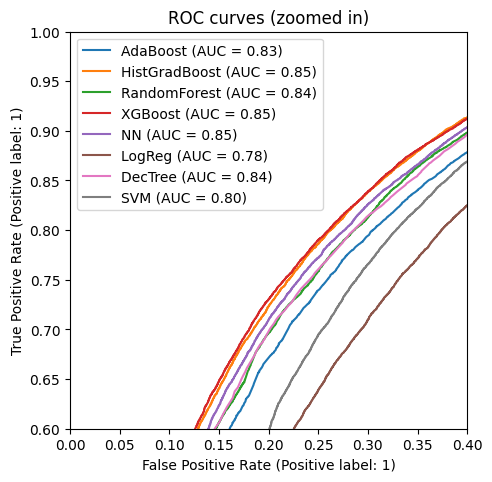

In [40]:
_, ax = plt.subplots(figsize=(5,5))

for name, _ in y_test_preds_list:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0.0, 0.4)
ax.set_ylim(0.6, 1.0)

plt.title('ROC curves (zoomed in)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/models-roc_curve-zoom.png', dpi=600)
plt.show()